In [61]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore")

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [63]:
df = pd.read_csv("../data/AmesHousing.csv")

df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('/','_')
df.columns = df.columns.str.lower()
df.columns

Index(['order', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod_add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
      

In [64]:
def neighbors_and_conditions_dict(X_train):
    neighbors_dict = {}
    for idx, value in enumerate(list(X_train.groupby('neighborhood').mean()['saleprice'].sort_values(ascending=True).index)):
        neighbors_dict[value] = idx 
        
    conditions_dict = {}
    for idx, value in enumerate(list(X_train.groupby('condition_1').mean()['saleprice'].sort_values(ascending=True).index)):
        conditions_dict[value] = idx 
        
    sale_condition_dict = {}
    for idx, value in enumerate(list(X_train.groupby('sale_condition').mean()['saleprice'].sort_values(ascending=True).index)):
        sale_condition_dict[value] = idx 
        
    # exterior_dict = {}
    # for idx, value in enumerate(list(X_train.groupby('exterior_1st').mean()['saleprice'].sort_values(ascending=True).index)):
    #     exterior_dict[value] = idx 
    # exterior_dict
    
    return neighbors_dict, conditions_dict, sale_condition_dict

In [65]:
def data_preprocessing(df, neighbors_dict, conditions_dict, sale_condition_dict ):

    dict_po_to_ex = { 'Po': 0, 'Fa': 1, 'TA': 2, "Gd": 3, "Ex": 4 }
    dict_na_to_ex = { np.nan : 0, 'Na': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 }
    dict_garage_finish = { 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3 }
    
    df['neighborhood_int'] = 0
    df.neighborhood_int = df.neighborhood.replace(neighbors_dict)     
    
    df['condition_int'] = 0
    df['condition_int'] = df['condition_1'].replace(conditions_dict)
    df['condition_int'] += df['condition_2'].replace(conditions_dict)

    df['sale_condition_int'] = 0
    df['sale_condition_int'] = df['sale_condition'].replace(sale_condition_dict)

    df['garage_qual_int'] = 0 
    df['garage_qual_int'] = df['garage_qual'].replace(dict_na_to_ex) 
    df['garage_qual_int'] = df['garage_qual_int'].fillna(3) # Represente la valeur la plus présente dans le jeu de données
    df['garage_qual_int'] = df['garage_qual_int'].astype(int)
    
    df['fireplace_qual'] = 0 
    df['fireplace_qual'] = df['fireplace_qu'].replace(dict_na_to_ex) 
    
    df['bsmt_qual_int'] = 0 
    df['bsmt_qual_int'] = df['bsmt_qual'].replace(dict_na_to_ex) 
    df['bsmt_qual_int'] = df['bsmt_qual_int'].fillna(0)
    df['bsmt_qual_int'] = df['bsmt_qual_int'].astype(int)


    df['heating_qc'] = df['heating_qc'].replace(dict_po_to_ex)
    df['heating_qc'] = df['heating_qc'].astype(int)

    df['exter_qual_int'] = 0 
    df['exter_qual_int'] = df['exter_qual'].replace(dict_po_to_ex) 
    df['exter_qual_int'] = df['exter_qual_int'].astype(int)

    df['kitchen_qual_int'] = 0 
    df['kitchen_qual_int'] = df['kitchen_qual'].replace(dict_po_to_ex) 
    df['kitchen_qual_int'] = df['kitchen_qual_int'].astype(int)
    
    df['garage_finish_int'] = 0 
    df['garage_finish_int'] = df['garage_finish'].replace(dict_garage_finish) 
    df['garage_finish_int'] = df['garage_finish_int'].fillna(df['garage_finish_int'].mean())
    df['garage_finish_int'] = df['garage_finish_int'].astype(int)
    
    df['central_air'] = np.where(df['central_air'] == "Y", 1, 0)
    df['central_air'] = df['central_air'].astype(int)
    
    # Analyse interessante de l'inutilité de la colonne land_slope (tres peu de maison en pente et prix élevé ++ des rares maisons en pentes vendu)
    # df.groupby('land_slope').mean()['SalePrice'].plot()
    # plt.title('Moyenne du prix des maisons en fonction de la pente')
    # plt.show()
    # df.groupby('land_slope').count()['SalePrice'].plot()
    # plt.title('Nombre de maisons vendus en fonction de la pente')
    # plt.show()

    df['land_slope'][df['land_slope'] == "Gtl"] = 0 
    df['land_slope'][df['land_slope'] == "Mod"] = 1 
    df['land_slope'][df['land_slope'] == "Sev"] = 2
    
    df.utilities[df.utilities == "NoSewr"] = 0 
    df.utilities[df.utilities == "NoSeWa"] = 1
    df.utilities[df.utilities == "AllPub"] = 2 
    df.utilities = df.utilities.astype(int)
    
    df['bsmt_exposure'][df['bsmt_exposure'] == np.nan ] = 0
    df['bsmt_exposure'][df['bsmt_exposure'] == "No"] = 1
    df['bsmt_exposure'][df['bsmt_exposure'] == "Mn"] = 2 
    df['bsmt_exposure'][df['bsmt_exposure'] == "Av"] = 3 
    df['bsmt_exposure'][df['bsmt_exposure'] == "Gd"] = 4
    
    df['paved_drive'][df['paved_drive'] == "N"] = 0 
    df['paved_drive'][df['paved_drive'] == "P"] = 1
    df['paved_drive'][df['paved_drive'] == "Y"] = 2 
    
    df.street[df.street == 'Pave'] = 10
    df.street[df.street == 'Grvl'] = 0
    df.street = df.street.astype(int)

    # df['exterior_int'] = 0
    # df['exterior_int'] = df['exterior_1st'].replace(exterior_dict)
    # df['exterior_int'] +=  np.where( df['Exterior 2nd'].replace(exterior_dict).isin(df['Exterior 2nd'].unique()) , 50, df['Exterior 2nd'].replace(exterior_dict))
    # df['exterior_int'] = df['exterior_int'].astype(int)
    
    return df

# Features engineering 

In [66]:
def data_engineering(df):
    
    # Caractéristique du garage. Plus le score est élevé, plus le garage est grand et/ou de qualité
    df['good_garage'] = 0 
    df['good_garage'] = df['garage_cars'] + (df['garage_finish_int'] *2) + (df['garage_qual_int'] *2 )
    df['good_garage'] = df['good_garage'].fillna(0)
    df['good_garage'][df['garage_area'] >= 575] += 2
    df['good_garage'] = df['good_garage'].astype(int)
    
    # Espace LowQualFinSF == Low quality finished square feet (all floors) est inclus dans le total => gr_liv_area (first_flr_sf + second_flr_sf + LowQualFinSF)
    # Je prend en compte l'espace supplémentaire mais je donne du poid à l'espace habitable sans la partie de faible qualité en ajoutant (first_flr_sf + second_flr_sf)
    df['main_living_area'] = df['gr_liv_area'] + df['total_bsmt_sf'].fillna(0) + df['first_flr_sf'] + df['second_flr_sf'] # + df['garage_area']
    
    # Je suis parti de l'idée d'ajouter tout les scores de qualité. J'ai aussi multiplié le nbr de cheminée par la qualité de la maison.
    # De sorte à augmenter le score des maisons ayant une cheminée ET une belle qualité général, et à pénalisé les maisons de mauvaises qualités avec cheminée.  
    df['quality_house'] = df['bsmt_qual_int'] + df['exter_qual_int'] + df['kitchen_qual_int'] + df['garage_qual_int'] +  ((df['fireplaces'] *  df['overall_qual']) /2) #*  df['overall_qual'] # + df['utilities'] # + df['overall_qual']
    
    # J'ajoute le nombre de salle de bain aux étages + rdc et j'applique un coéfficient sur les salle de bain non complete pour les pénalisés 
    df['total_bath'] = 0 
    df['total_bath'] = df['full_bath'] + (df['half_bath'] /2) + df['bsmt_full_bath'].fillna(0) + (df['bsmt_half_bath'].fillna(0) /1.5 )# / df['overall_qual'] # + df['TotRms AbvGrd'] 

    # Colonne qui encode pour la qualité du mur exterieur ou du jardin, de la rue et la presence de la climatisation, 
    # la route pavé semble couté plus chère qu'une route en gravié pour la colonnne street et la colonne paved_drive
    # bsmt_exposure => Qualité murs trottoire, jaridns.  
    df['qual_walkout_clim'] = df['bsmt_exposure'].fillna(0) + df['paved_drive'] + df['street'] + df['central_air'] 
    df.qual_walkout_clim = df.qual_walkout_clim.astype(float)    
    
    # Score general de la maison, je multiplie certains critère de qualité. Le 0 est possible uniquement dans utilities. 
    # Ce qui permet de mettre un lourd poid negatif quand il n'y a pas de fausse septique pour traiter les eaux usées.
    # A l'inverse plus les qualités seront élevé et plus le score le sera aussi.  
    df['main_score_house'] = 0 
    df['main_score_house'] = df['overall_qual'] * df['neighborhood_int'] * df['quality_house'] * df['total_bath'] * df['utilities'] 
    
    df['options_in_house'] = 0 
    # Là ou belle maison, beau quartier, et espace vivable important
    df['options_in_house'][(df['overall_qual']>=6) & (df['neighborhood_int'] >= 17) & (df['main_living_area'] >= 4000)] +=1
    # Open porch area in square feet (genre de balcon au rdc (typique usa))
    df['options_in_house'][(df['open_porch_sf'] > 0)] += 1
    # Wood deck area in square feet (surface terrasse en bois)
    df['options_in_house'][(df['wood_deck_sf'] > 0)] += 1
    # Là ou on a une piscine 
    df['options_in_house'][(df['pool_area'] > 0 )] += 1
    # Là ou on a de l'espace à l'étage 
    df['options_in_house'][df['gr_liv_area'] >= 1800] += 1
    # Qualité du chauffage 
    df['options_in_house'] += df['heating_qc']
    # Ajoute du poid si route pavé et clim. 
    df['options_in_house'] += df['qual_walkout_clim']
    # Ajoute du poid si axe routier interessant, grosse artère etc.
    df['options_in_house'] += df['condition_int']
    df['options_in_house'] = df.options_in_house.astype(int)
    
    return df 

In [ ]:
to_keep = ['overall_qual', 'neighborhood_int', 'exterior_1st', 'year_remod_add', 'quality_house', 
            'main_score_house', 'options_in_house', 'main_living_area', 'good_garage', 'sale_condition_int',
                'SalePrice']

In [ ]:
# Recap info des colonnes que j'ai choisis
formulaire = []
'overall_qual' -> 0 à 11 

'neighborhood_int' -> ['NAmes', 'Gilbert', 'StoneBr', 'NWAmes', 'Somerst', 'BrDale',
       'NPkVill', 'NridgHt', 'Blmngtn', 'NoRidge', 'SawyerW', 'Sawyer',
       'Greens', 'BrkSide', 'OldTown', 'IDOTRR', 'ClearCr', 'SWISU',
       'Edwards', 'CollgCr', 'Crawfor', 'Blueste', 'Mitchel', 'Timber',
       'MeadowV', 'Veenker', 'GrnHill', 'Landmrk']

'year_remod_add' -> 1800 à current_year +1

'exterior_1st' -> ['BrkFace', 'VinylSd', 'Wd Sdng', 'CemntBd', 'HdBoard', 'Plywood',
       'MetalSd', 'AsbShng', 'WdShing', 'Stucco', 'AsphShn', 'BrkComm',
       'CBlock', 'PreCast', 'Stone', 'ImStucc']

'quality_house' -> df['bsmt_qual_int'] + df['exter_qual_int'] + df['kitchen_qual_int'] + df['garage_qual_int'] +  ((df['fireplaces'] *  df['overall_qual']) /2)
                     bsmt_qual_int -> bsmt_qual -> ['TA', 'Gd', 'Ex', nan, 'Fa', 'Po']
                     exter_qual_int -> exter_qual -> ['TA', 'Gd', 'Ex', 'Fa']
                     kitchen_qual_int -> kitchen_qual -> ['TA', 'Gd', 'Ex', 'Fa', 'Po']
                     garage_qual_int -> garage_qual - > ['TA', nan, 'Fa', 'Gd', 'Ex', 'Po']
                     fireplaces -> 0 à 4 

'main_score_house' -> df['overall_qual'] * df['neighborhood_int'] * df['quality_house'] * df['total_bath'] * df['utilities'] 
                     total_bath -> df['full_bath'] + (df['half_bath'] /2) + df['bsmt_full_bath'].fillna(0) + (df['bsmt_half_bath'].fillna(0) /1.5 )
                                   full_bath -> 0 à 4
                                   half_bath -> 0 à 2 
                                   bsmt_full_bath -> 0 à 3 
                                   bsmt_half_bath -> 0 à 3
                     utilities -> ['AllPub', 'NoSewr', 'NoSeWa']
                     
options_in_house - > main_living_area -> df['gr_liv_area'] + df['total_bsmt_sf'].fillna(0) + df['first_flr_sf'] + df['second_flr_sf']
                     gr_liv_area -> Surface 
                     total_bsmt_sf - > Surface 
                     first_flr_sf -> Surface 
                     second_flr_sf -> Surface 
                     open_porch_sf 
                     wood_deck_sf
                     pool_area -> Surface 
                     heating_qc > ['Fa', 'TA', 'Ex', 'Gd', 'Po']
                     qual_walkout_clim -> df['bsmt_exposure'].fillna(0) + df['paved_drive'] + df['street'] + df['central_air'] 
                                   bsmt_exposure -> ['Gd', 'No', 'Mn', 'Av', nan]
                                   paved_drive -> ['P', 'Y', 'N']
                                   street -> ['Pave', 'Grvl']
                                   central_air -> ['Y', 'N'] 
                     condition_int ->     condition_1 -> ['Norm', 'Feedr', 'PosN', 'RRNe', 'RRAe', 'Artery', 'PosA', 'RRAn', 'RRNn']
                                          condition_2 -> ['Norm', 'Feedr', 'PosA', 'PosN', 'Artery', 'RRNn', 'RRAe', 'RRAn']
                                          
good_garage -> df['garage_cars'] + (df['garage_finish_int'] *2) + (df['garage_qual_int'] *2 ) garage_area 
              -> garage_cars -> 0 à 10 ? 
              -> garage_finish_int -> garage_finish -> ['Fin', 'Unf', 'RFn', nan] 
              -> Garage area -> Surface 
       
sale_condition_int -> sale_condition -> ['Normal', 'Partial', 'Family', 'Abnorml', 'Alloca', 'AdjLand']


In [56]:
df['fireplace_qu'].unique()

array(['Gd', nan, 'TA', 'Po', 'Ex', 'Fa'], dtype=object)

In [ ]:
df.head(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,2001,2001,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,616.0,Unf,0.0,722.0,1338.0,GasA,Ex,Y,SBrkr,1338,0,0,1338,1.0,0.0,2,0,2,1,Gd,6,Typ,0,NaN,Attchd,2001.0,Fin,2.0,582.0,TA,TA,Y,0,0,170,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1995,1996,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1180.0,Unf,0.0,415.0,1595.0,GasA,Ex,Y,SBrkr,1616,0,0,1

# Features selections:

In [245]:
def features_selection(df):
    to_keep = ['overall_qual', 'neighborhood_int', 'exterior_1st', 'year_remod_add', 'quality_house', 
               'main_score_house', 'options_in_house', 'main_living_area', 'good_garage', 'sale_condition_int',
                 'SalePrice']
    return df[to_keep]

# Apply processing, analyze and Visualization:

In [246]:
# Import data
df = pd.read_csv("data/AmesHousing.csv")

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(df, df.SalePrice, test_size=0.25, random_state=42)
neighbors_dict, conditions_dict, sale_condition_dict = neighbors_and_conditions_dict(X_train)

df_all = data_engineering(data_preprocessing(df, neighbors_dict, conditions_dict, sale_condition_dict))
df_transformed = features_selection(data_engineering(data_preprocessing(df, neighbors_dict, conditions_dict, sale_condition_dict)))

df_transformed

,Overall Qual,Neighborhood_int,Exterior 1st,Year Remod/Add,quality_house,main_score_house,options_in_house,main_living_area,good_garage,sale_condition_int,SalePrice
0,6,11,BrkFace,1960,14.0,3696.0,26,4392.0,14,4,215000
1,5,11,VinylSd,1961,10.0,1100.0,21,2674.0,11,4,105000
2,6,11,Wd Sdng,1958,11.0,2178.0,25,3987.0,9,4,172000
3,7,11,BrkFace,1968,16.0,8624.0,26,6330.0,14,4,244000
4,5,15,VinylSd,1998,12.5,4687.5,26,4186.0,14,4,189900
...,...,...,...,...,...,...,...,...,...,...,...
2925,6,12,HdBoard,1984,10.0,2880.0,26,3009.0,12,4,142500
2926,5,12,HdBoard,1983,11.0,2640.0,26,2668.0,10,4,131000
2927,5,12,HdBoard,1992,8.0,1600.0,27,2852.0,2,4,132000
2928,5,12,HdBoard,1975,12.5,3000.0,28,4167.0,12,4,170000


Text(0.5, 1.0, 'Mean price ordered by lower to higher physical locations')

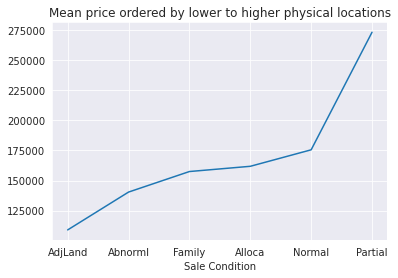

In [218]:
df_all.groupby('sale_condition').mean()['SalePrice'].sort_values(ascending=True).plot()
plt.title('Mean price ordered by lower to higher physical locations')

## Heatmap

<AxesSubplot:>

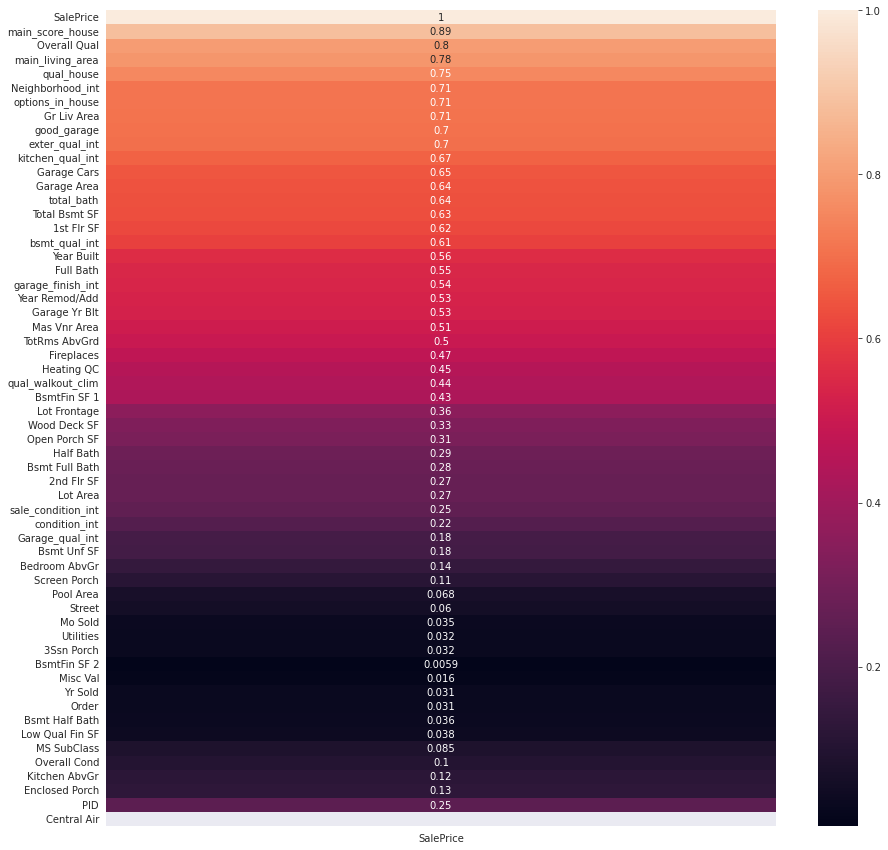

In [162]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(np.abs(data_engineering(data_preprocessing(df_all, neighbors_dict, conditions_dict, sale_condition_dict )).corr()[['SalePrice']].sort_values('SalePrice', ascending = False)), annot=True)

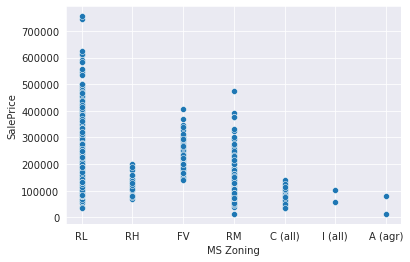

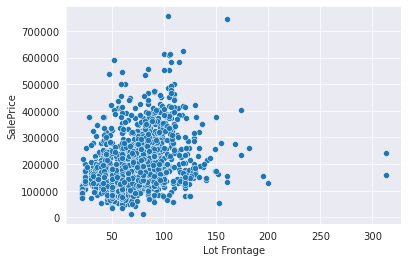

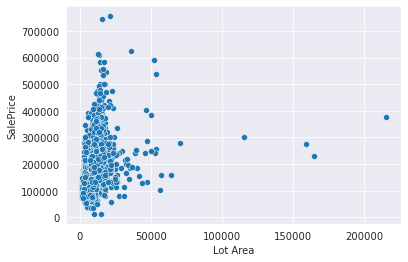

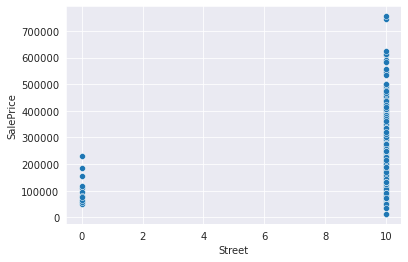

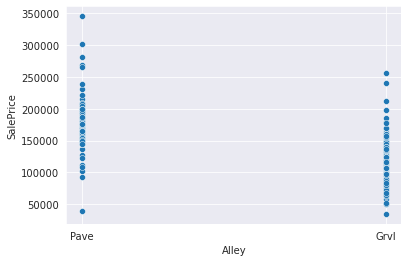

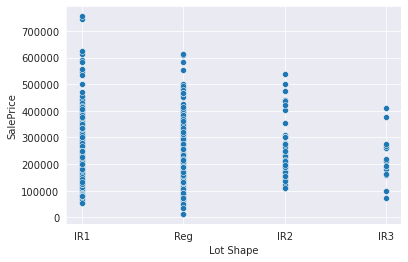

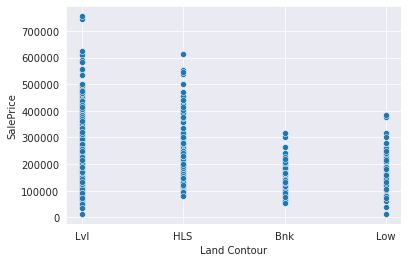

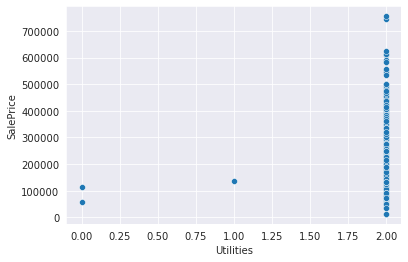

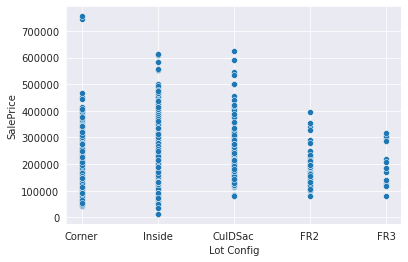

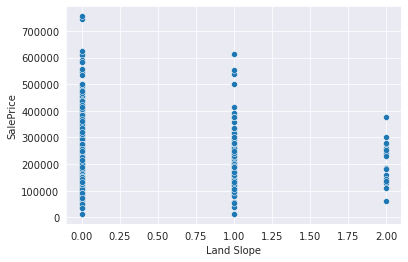

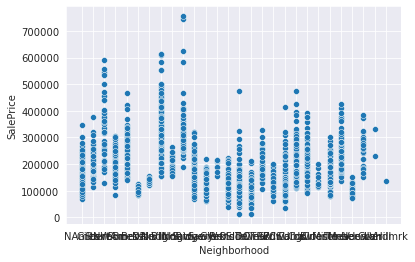

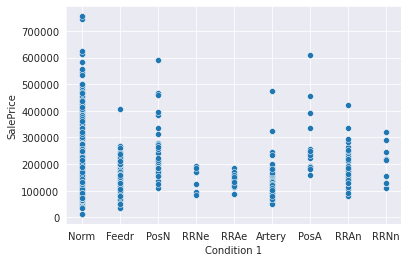

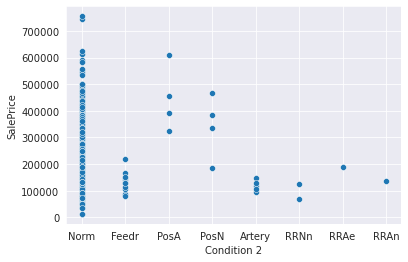

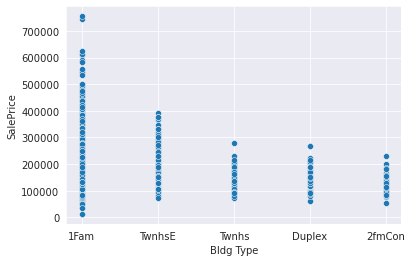

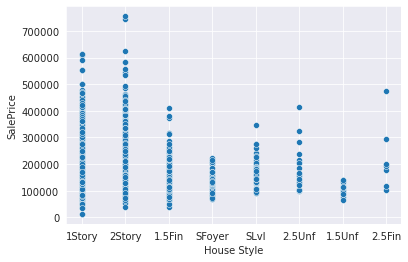

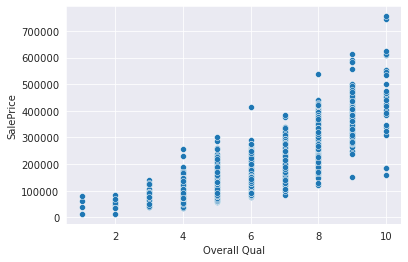

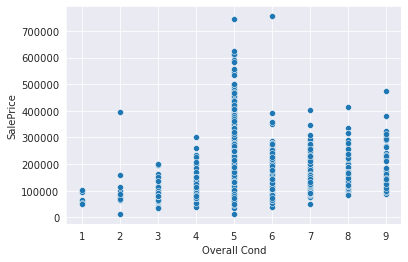

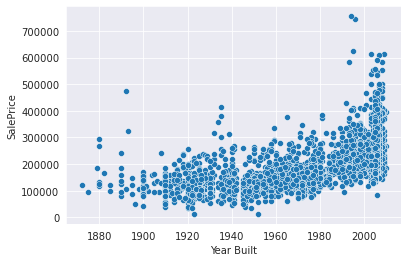

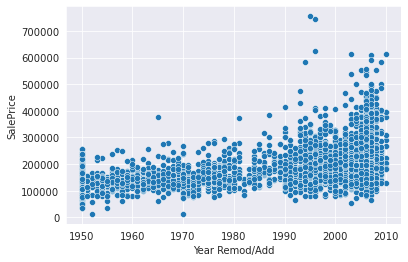

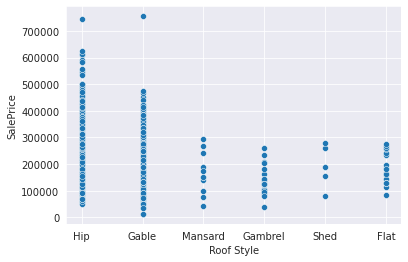

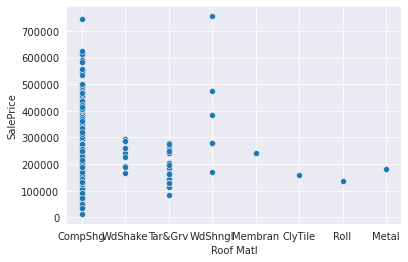

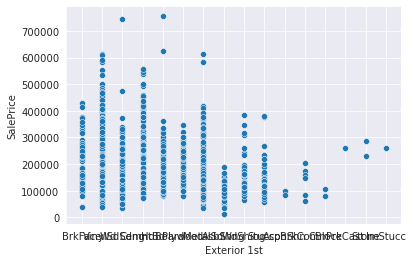

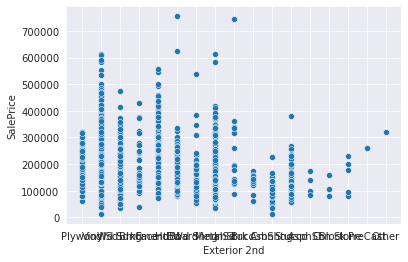

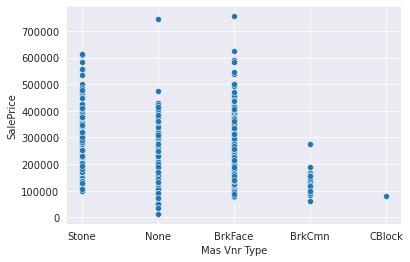

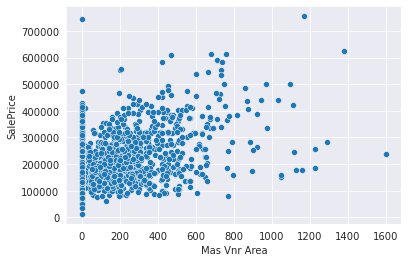

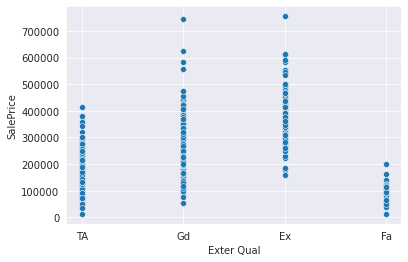

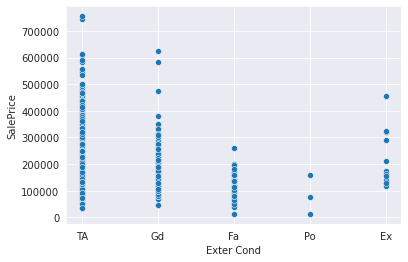

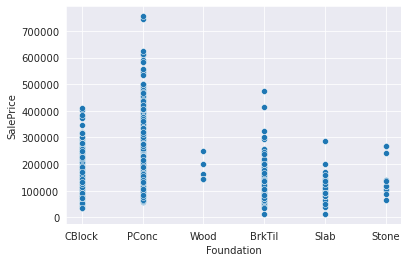

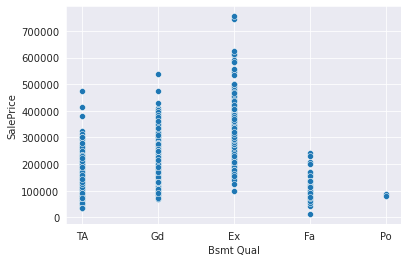

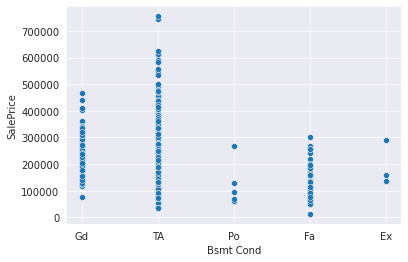

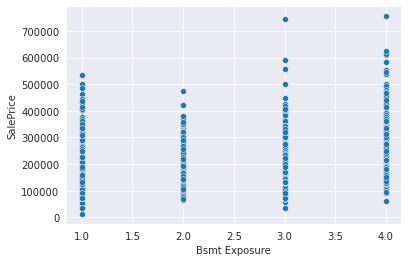

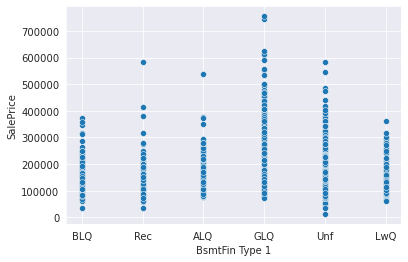

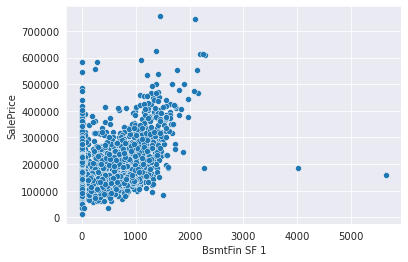

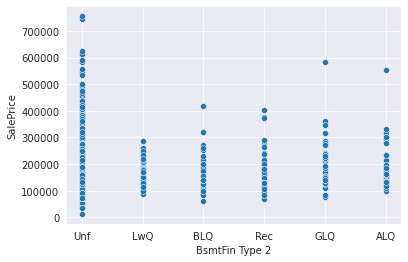

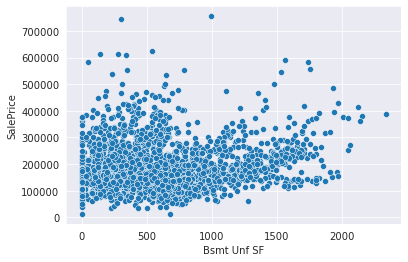

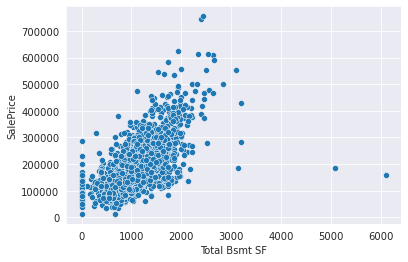

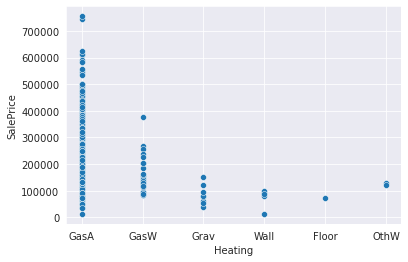

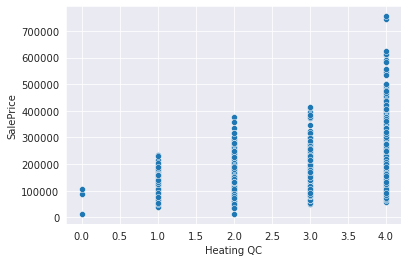

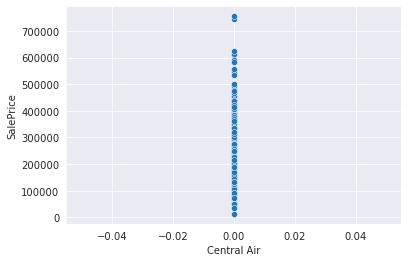

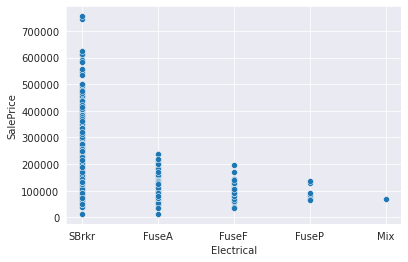

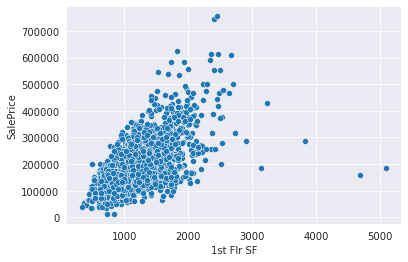

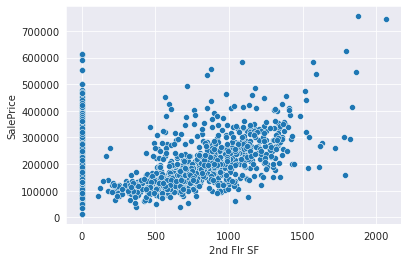

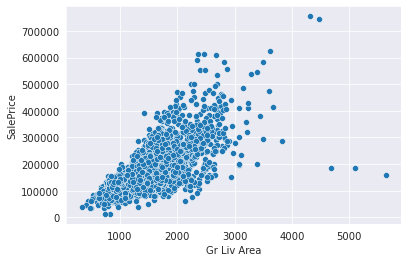

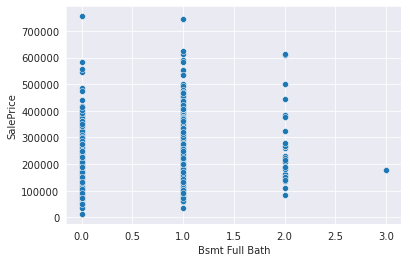

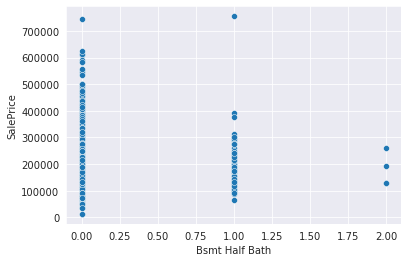

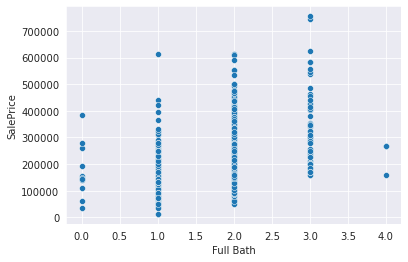

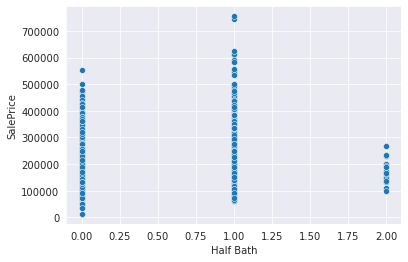

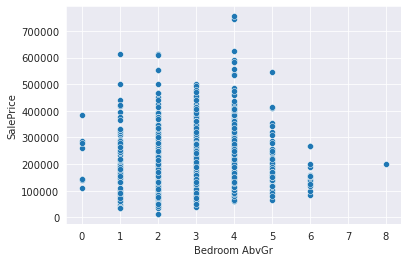

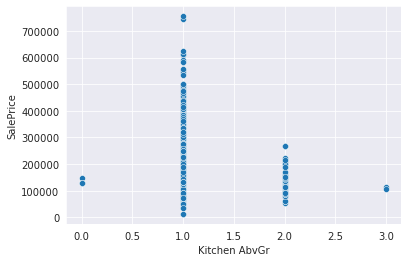

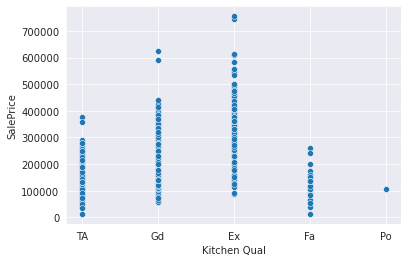

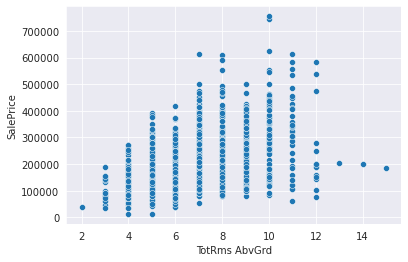

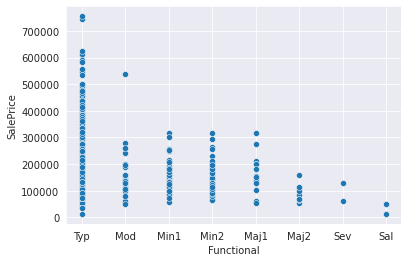

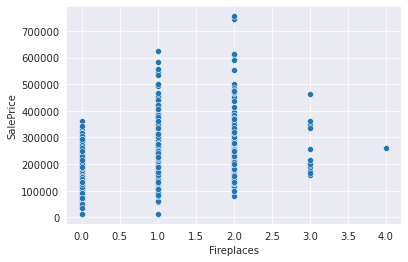

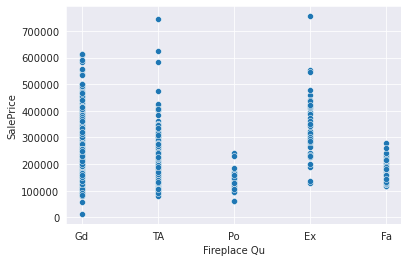

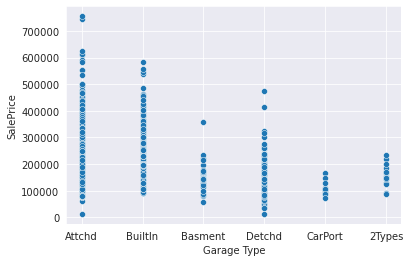

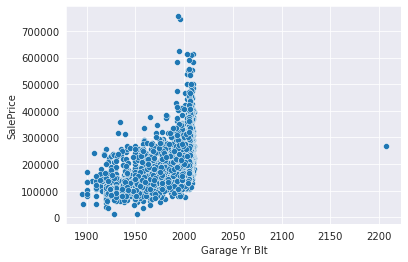

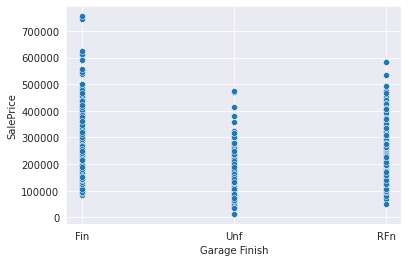

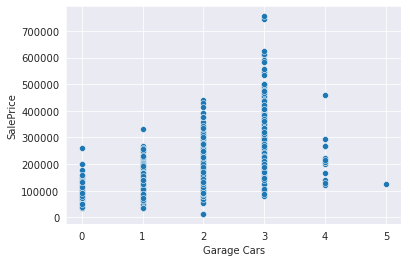

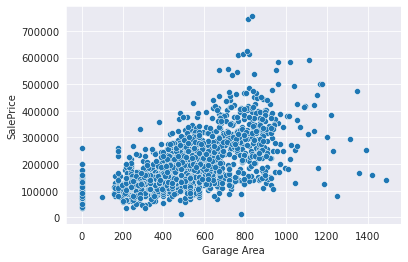

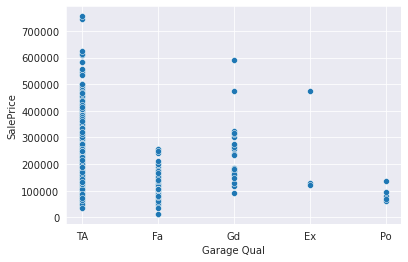

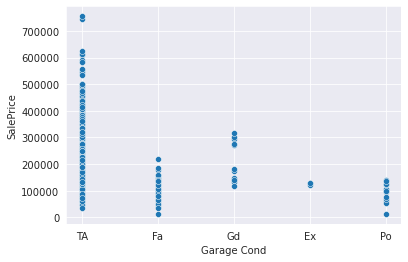

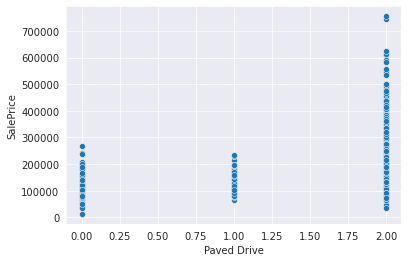

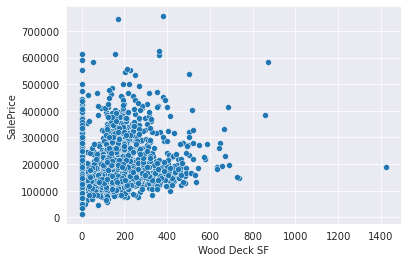

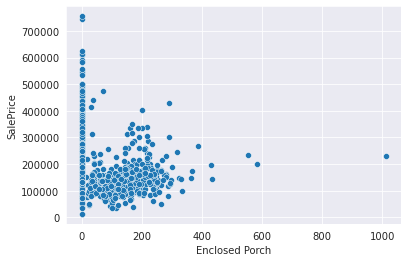

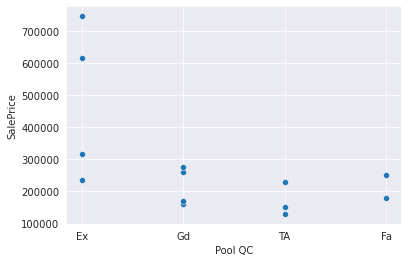

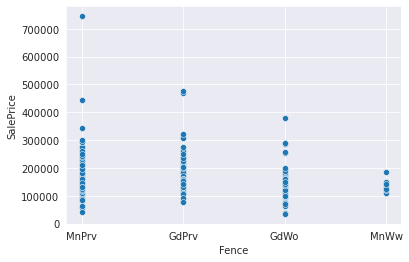

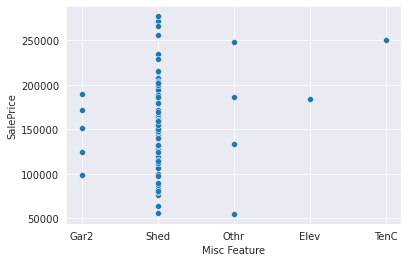

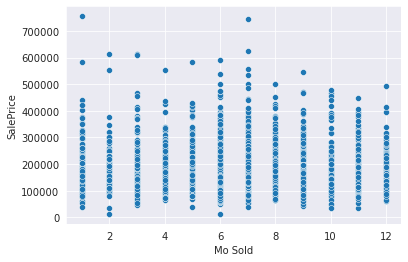

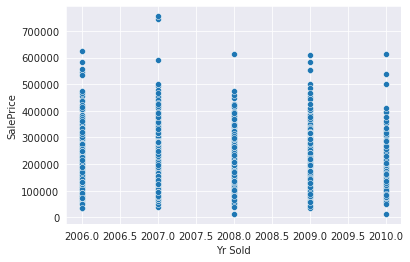

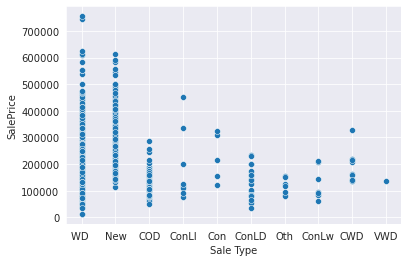

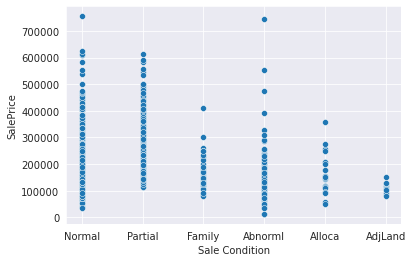

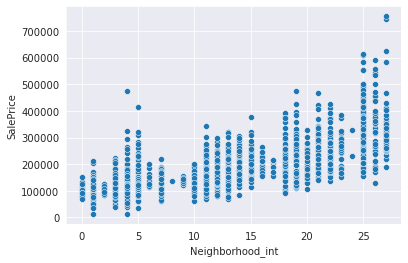

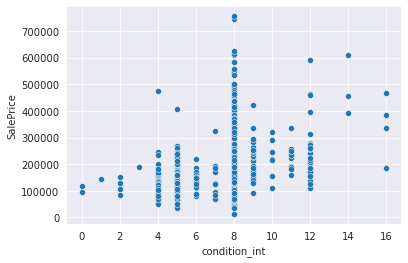

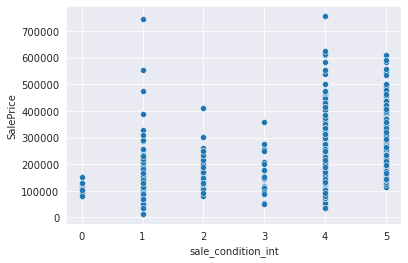

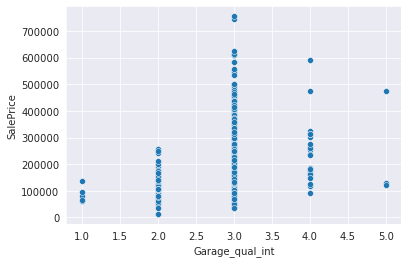

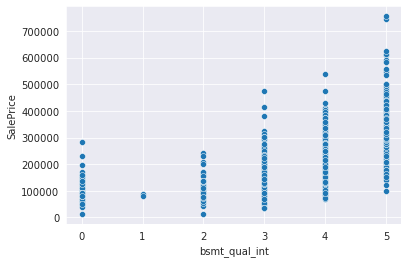

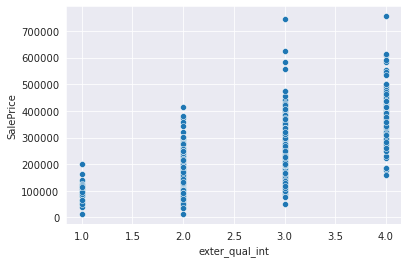

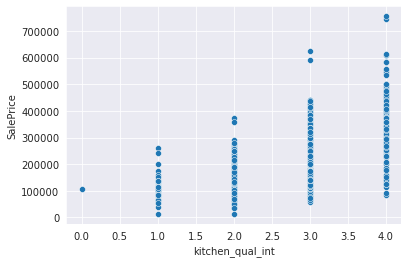

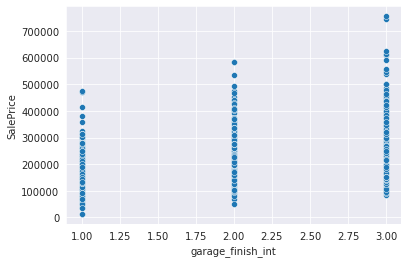

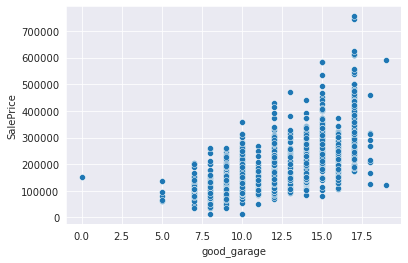

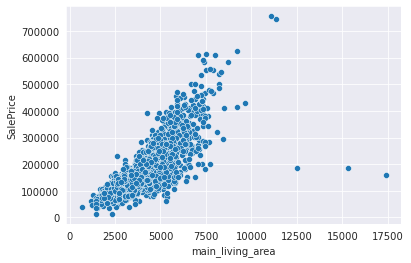

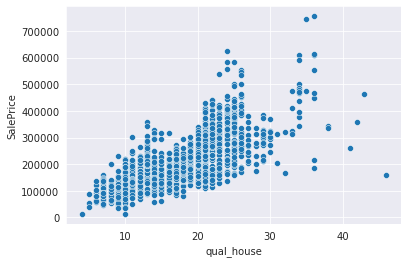

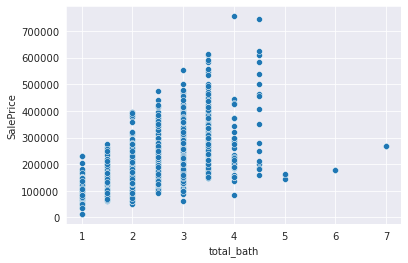

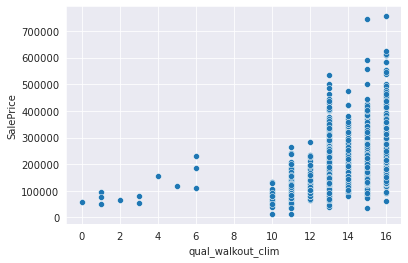

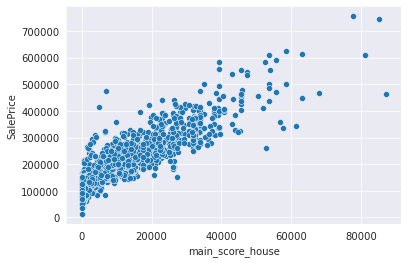

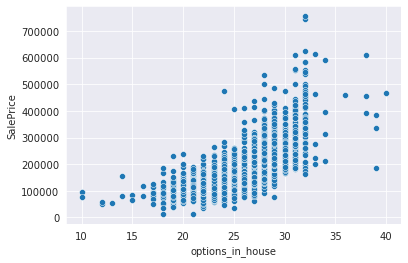

In [191]:
for col in df_all.columns.drop(['SalePrice', 'Order', 'PID', 'MS SubClass','BsmtFin SF 2','Low Qual Fin SF', 'open_porch_sf','Screen Porch',
        'pool_area', 'Misc Val', "3Ssn Porch"]):
    sns.scatterplot(df_all[col], df_all['SalePrice'])
    plt.show()

<AxesSubplot:>

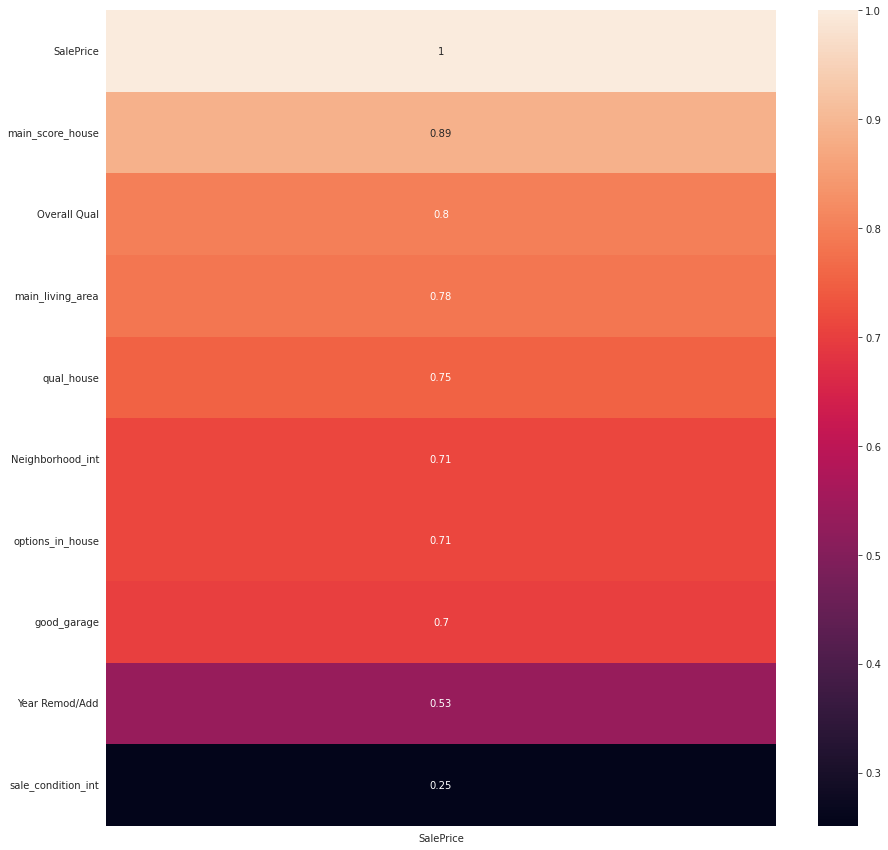

In [163]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(np.abs(df_transformed.corr()[['SalePrice']].sort_values('SalePrice', ascending = False)), annot=True)

## Verification des scores creer: 

In [ ]:
for i in range(10,df_transformed.shape[0], 100):
    print(df_transformed.sort_values('quality_house',ascending=False).head(i).mean()['SalePrice'])

461222.3
391303.7818181818
356935.56666666665
333237.835483871
311791.1268292683
295091.98039215687
285182.22786885244
276394.9394366197
268305.1814814815
260152.67472527473
253011.03465346535
248383.33873873873
242747.45619834712
237188.7641221374
232047.39787234043
227893.58675496688
223614.56583850933
218978.80175438596
214686.49668508288
210946.6952879581
207951.2184079602
205104.7511848341
201226.14705882352
198010.88484848486
195004.6979253112
192067.93824701195
189639.16283524904
187250.96863468635
184323.44306049822
181445.76013745705


In [ ]:
for i in range(10,df_transformed.shape[0], 100):
    print(df_transformed.sort_values('main_score_house',ascending=False).head(i).mean()['SalePrice'])

555041.4
403746.92727272725
364072.2428571429
339231.9903225806
317212.99024390243
300993.1803921569
288892.3557377049
278312.01830985915
270445.3740740741
262995.8142857143
256935.34356435644
250330.06036036037
244932.75867768595
240030.82366412214
235068.5340425532
230124.7735099338
225554.9397515528
221113.79356725147
216628.70828729283
212976.3832460733
209467.715920398
206111.54028436018
202840.07647058825
199704.0974025974
196595.93278008298
193655.68167330677
190562.78007662835
187640.78819188193
184670.85978647688
181409.06563573884


In [ ]:
for i in range(10,df_all.shape[0], 100):
    print(df_all.sort_values('total_bath',ascending=False).head(i).mean()['SalePrice'])

300330.0
290326.62727272726
290431.8333333333
283039.4709677419
273659.3829268293
265862.8431372549
261015.60819672132
256628.30422535213
250033.33580246914
244948.4846153846
241142.43762376238
237591.3171171171
233165.96363636362
230227.2900763359
225039.78014184398
221034.87218543046
216577.92298136646
213685.7216374269
210189.36132596686
206857.12984293193
204266.207960199
201843.03981042653
200188.50226244345
197256.84415584416
194982.11410788383
192593.27131474102
189415.0816091954
186560.80922509226
183771.4462633452
181260.77525773196


## Visualisation

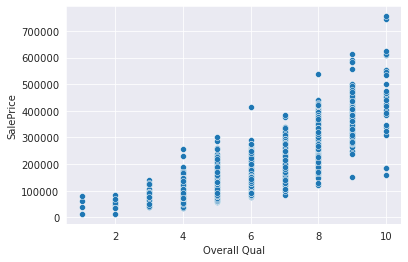

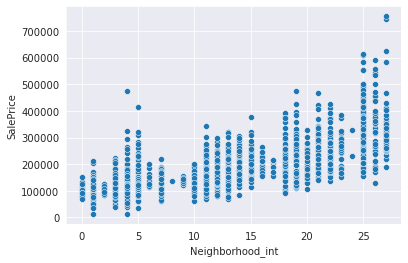

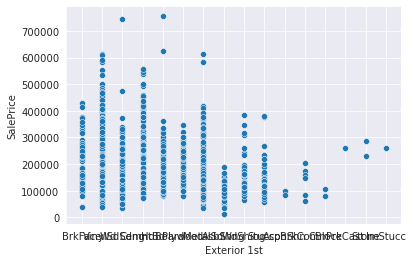

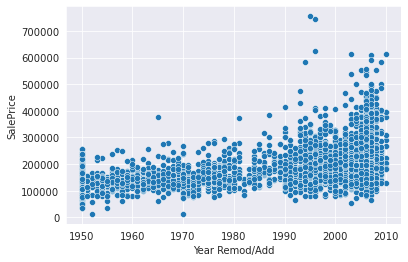

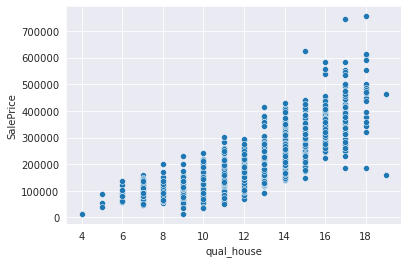

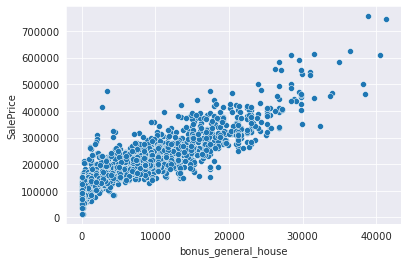

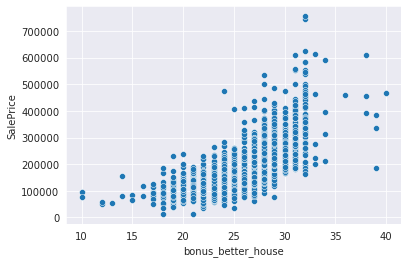

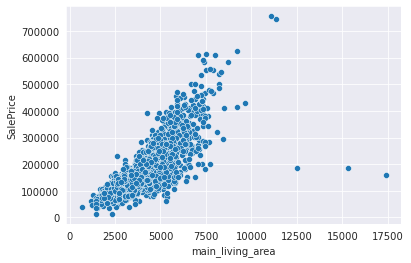

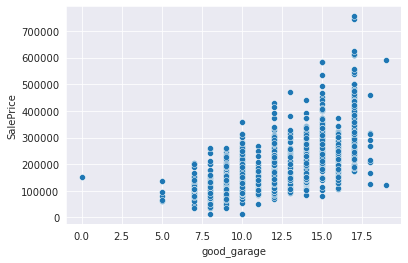

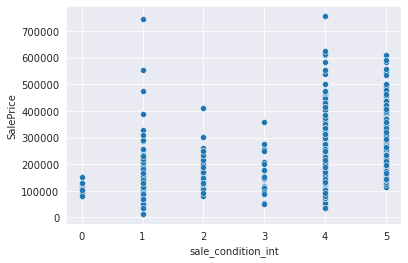

In [123]:
for col in df_transformed.columns.drop('SalePrice'):
    sns.scatterplot(df_transformed[col], df_transformed['SalePrice'])
    plt.show()

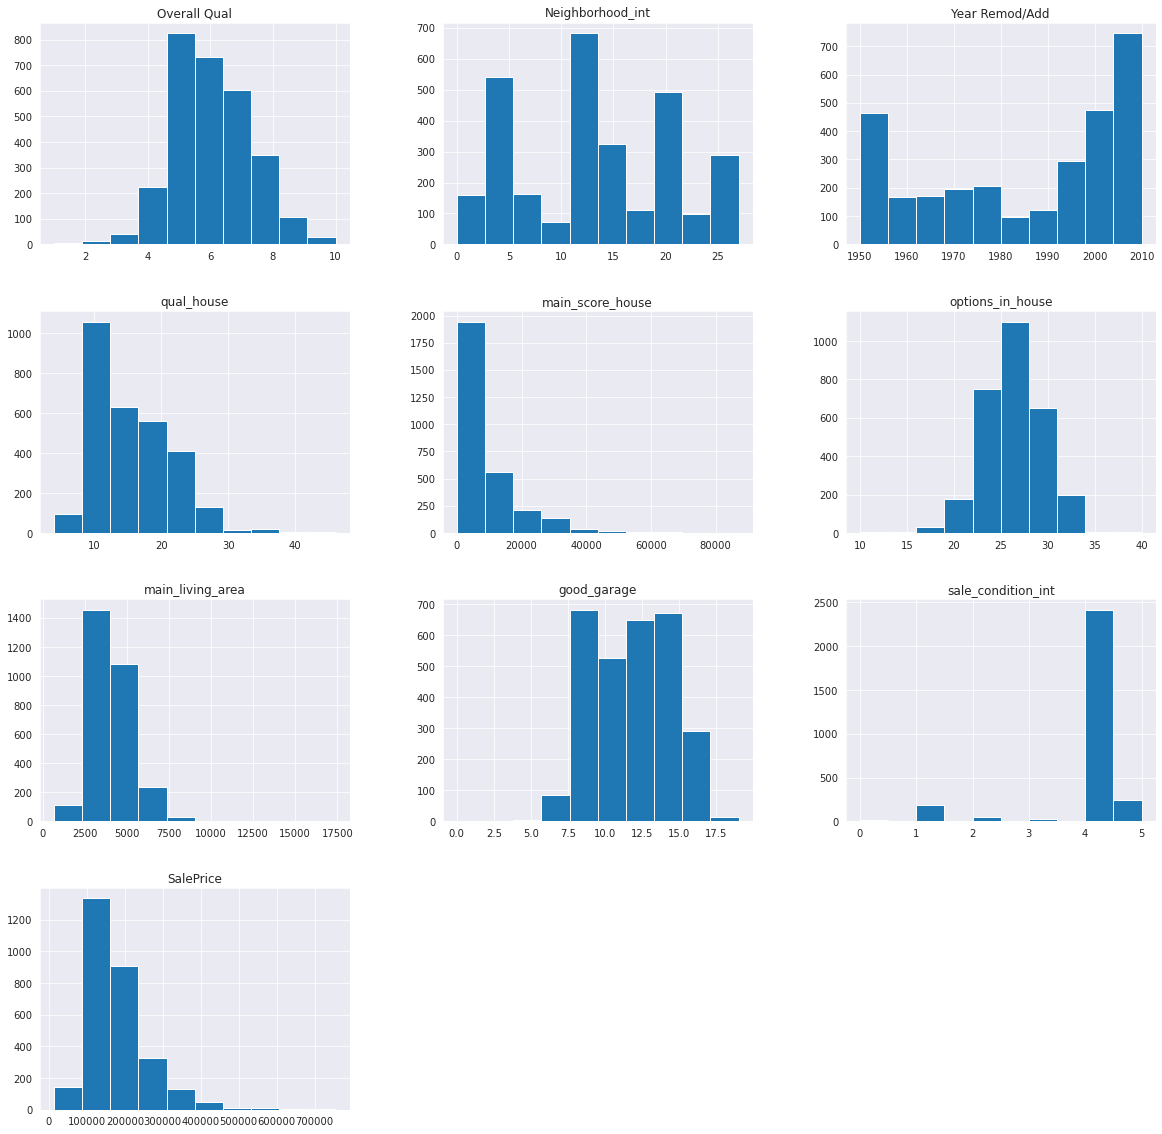

In [164]:
df_transformed.hist(figsize=(20,20))
plt.show()

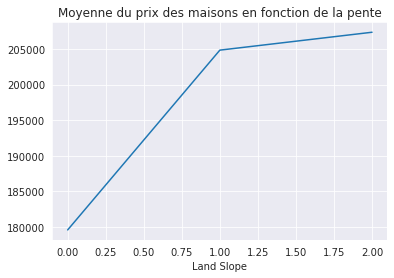

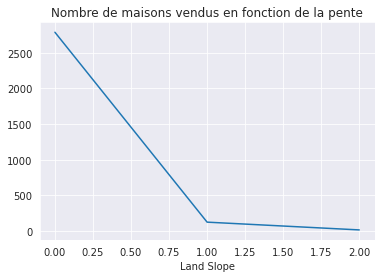

In [129]:
df.groupby('land_slope').mean()['SalePrice'].plot()
plt.title('Moyenne du prix des maisons en fonction de la pente')
plt.show()
df.groupby('land_slope').count()['SalePrice'].plot()
plt.title('Nombre de maisons vendus en fonction de la pente')
plt.show()


<AxesSubplot:xlabel='Exterior 1st'>

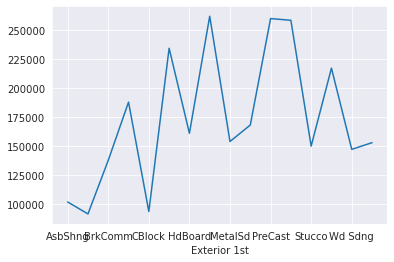

In [105]:
df.groupby('exterior_1st').mean()['SalePrice'].plot()

<AxesSubplot:xlabel='Exterior 2nd'>

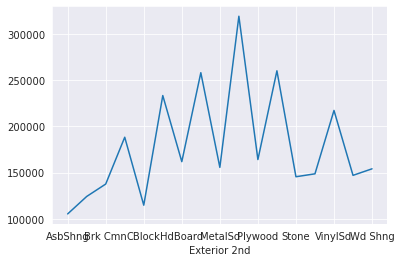

In [98]:
df.groupby('Exterior 2nd').mean()['SalePrice'].plot()

<AxesSubplot:xlabel='Land Contour'>

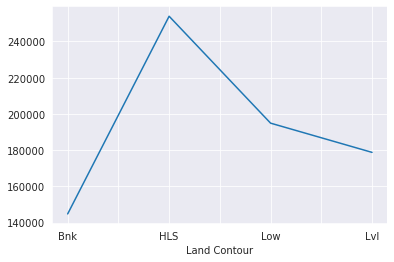

In [555]:
df.groupby('Land Contour').mean()['SalePrice'].plot()

<AxesSubplot:xlabel='Roof Style'>

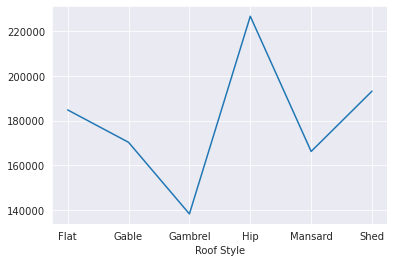

In [556]:
df.groupby('Roof Style').mean()['SalePrice'].plot()

<AxesSubplot:xlabel='Bsmt Exposure'>

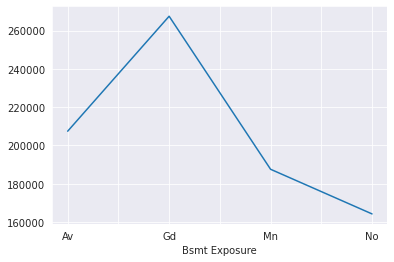

In [243]:
df.groupby('bsmt_exposure').mean()['SalePrice'].plot()

<AxesSubplot:xlabel='Utilities'>

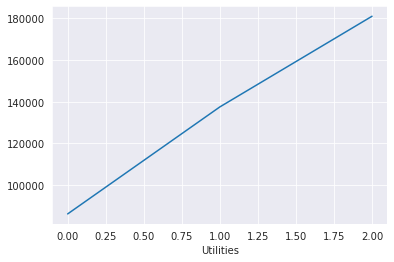

In [197]:
df.groupby('utilities').mean()['SalePrice'].plot()

<AxesSubplot:xlabel='Paved Drive'>

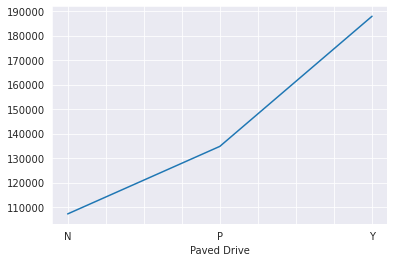

In [316]:
df.groupby('paved_drive').mean()['SalePrice'].plot()

In [269]:
df['year_remod_add'].unique()

array([1960, 1961, 1958, 1968, 1998, 2001, 1992, 1996, 1999, 1994, 2007,
       1990, 1985, 2003, 2005, 2010, 1951, 1988, 1977, 1974, 2000, 1970,
       2008, 1971, 1975, 1978, 2006, 2004, 2002, 1995, 2009, 1980, 1979,
       1984, 1981, 1950, 1967, 1963, 1993, 1966, 1959, 1964, 1954, 1972,
       1989, 1957, 1956, 1952, 1955, 1962, 1997, 1965, 1969, 1987, 1976,
       1991, 1973, 1986, 1983, 1953, 1982])

AxesSubplot(0.125,0.125;0.775x0.755)


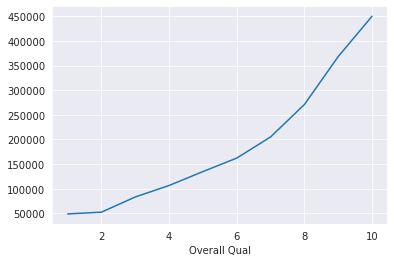

AxesSubplot(0.125,0.125;0.775x0.755)


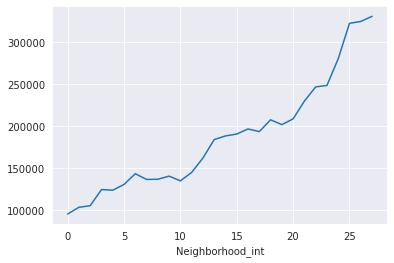

AxesSubplot(0.125,0.125;0.775x0.755)


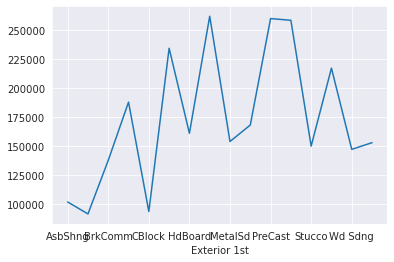

AxesSubplot(0.125,0.125;0.775x0.755)


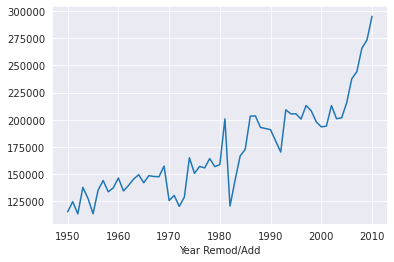

AxesSubplot(0.125,0.125;0.775x0.755)


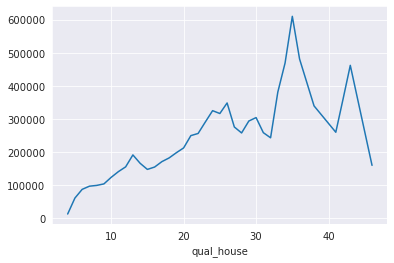

AxesSubplot(0.125,0.125;0.775x0.755)


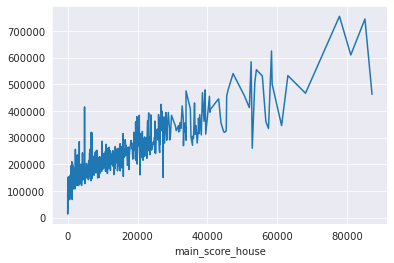

AxesSubplot(0.125,0.125;0.775x0.755)


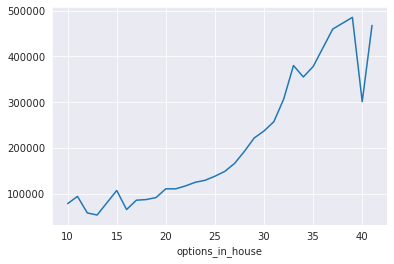

AxesSubplot(0.125,0.125;0.775x0.755)


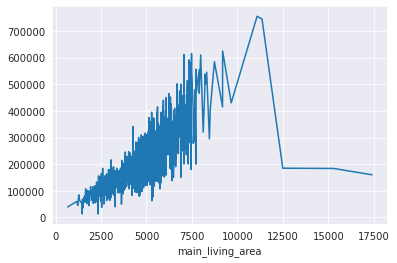

AxesSubplot(0.125,0.125;0.775x0.755)


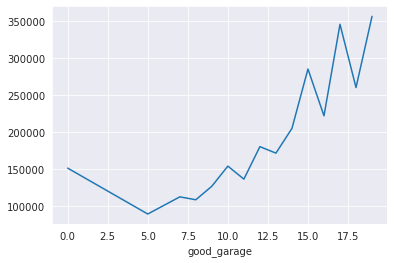

AxesSubplot(0.125,0.125;0.775x0.755)


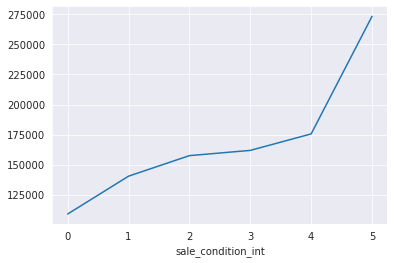

In [165]:
# Import data
df = pd.read_csv("data/AmesHousing.csv")
X_train, X_test, y_train, y_test = train_test_split(df, df.SalePrice, test_size=0.25, random_state=42)
neighbors_dict, conditions_dict, sale_condition_dict = neighbors_and_conditions_dict(X_train)

df_transformed = features_selection(data_engineering(data_preprocessing(df, neighbors_dict, conditions_dict, sale_condition_dict)))

for col in df_transformed.columns:
    if col != "SalePrice":
        print(df_transformed.groupby(col).mean()['SalePrice'].plot())
        plt.show()

# Model training

In [87]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

def features_selection(df):
    to_keep = ['overall_qual', 'neighborhood_int', 'exterior_1st', 'year_remod_add', 'quality_house', 
               'main_score_house', 'options_in_house', 'main_living_area', 'good_garage', 'sale_condition_int',
                 'saleprice']
    return df[to_keep]

# Import data and normalize columns names
df = pd.read_csv("../data/AmesHousing.csv")
df.columns = df.columns.str.replace('1st Flr SF','first_flr_sf')
df.columns = df.columns.str.replace('2nd Flr SF','second_flr_sf')
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('/','_')
df.columns = df.columns.str.lower()

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(df, df.saleprice, test_size=0.2, random_state=42)

# Preprocessing and features ingeneering 
neighbors_dict, conditions_dict, sale_condition_dict = neighbors_and_conditions_dict(X_train)
X_train = features_selection(data_engineering(data_preprocessing(X_train, neighbors_dict, conditions_dict, sale_condition_dict))).drop('saleprice', axis=1)
X_test = features_selection(data_engineering(data_preprocessing(X_test, neighbors_dict, conditions_dict, sale_condition_dict))).drop('saleprice', axis=1)

# Models pipelines and features selections for each pipeline 
pipelines_1 = make_pipeline(MinMaxScaler())
pipelines_2 = make_pipeline( OneHotEncoder(handle_unknown='ignore'))
pipelines_3 = make_pipeline( OrdinalEncoder())

columns_1 = list(X_train.columns.drop(['exterior_1st','overall_qual', 'sale_condition_int']))
columns_2 = list(X_train.columns.drop(['year_remod_add', 'main_score_house', 'main_living_area']))
columns_3 = ['neighborhood_int', 'options_in_house', 'good_garage']

# Apply preprocessing and fit 
preprocessing_model = make_column_transformer((pipelines_1, columns_1), 
                                              (pipelines_2, columns_2), 
                                              (pipelines_3, columns_3),
                                              )
model = make_pipeline(preprocessing_model, LinearRegression())
model.fit(X_train, y_train)

# Models scoring
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
print('R2 score on train data: ', model.score(X_train, y_train))
print('R2 score on test data: ', model.score(X_test, y_test))
print('MAE on train data: ', mean_absolute_error(y_train, predict_train))
print('MAE on test data: ',  mean_absolute_error(y_test, predict_test))


from joblib import dump
dump(model, "../fit/model.joblib")
print('model.joblib saved')

R2 score on train data:  0.9130469663694639
R2 score on test data:  0.9146120769785575
MAE on train data:  15073.02876341937
MAE on test data:  16650.201538970145
model.joblib saved


In [80]:
from sklearn.preprocessing import PolynomialFeatures

def features_selection(df):
    to_keep = ['overall_qual', 'neighborhood_int', 'exterior_1st', 'year_remod_add', 'quality_house', 
               'main_score_house', 'options_in_house', 'main_living_area', 'good_garage', 'sale_condition_int',
                 'saleprice']
    return df[to_keep]

# Import data and normalize columns names
df = pd.read_csv("../data/AmesHousing.csv")
df.columns = df.columns.str.replace('1st Flr SF','first_flr_sf')
df.columns = df.columns.str.replace('2nd Flr SF','second_flr_sf')
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('/','_')
df.columns = df.columns.str.lower()

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(df, df.saleprice, test_size=0.2, random_state=42)

# Preprocessing and features ingeneering 
neighbors_dict, conditions_dict, sale_condition_dict = neighbors_and_conditions_dict(X_train)
X_train = features_selection(data_engineering(data_preprocessing(X_train, neighbors_dict, conditions_dict, sale_condition_dict))).drop('saleprice', axis=1)
X_test = features_selection(data_engineering(data_preprocessing(X_test, neighbors_dict, conditions_dict, sale_condition_dict))).drop('saleprice', axis=1)

# Models pipelines and features selections for each pipeline 
pipelines_1 = make_pipeline(SimpleImputer())
pipelines_2 = make_pipeline( OneHotEncoder(handle_unknown='ignore'))
pipelines_3 = make_pipeline( OrdinalEncoder())

columns_1 = list(X_train.columns.drop(['exterior_1st','overall_qual', 'sale_condition_int']))
columns_2 = list(X_train.columns.drop(['year_remod_add', 'main_score_house', 'main_living_area']))
columns_3 = ['neighborhood_int', 'options_in_house', 'good_garage']

# Apply preprocessing and fit 
preprocessing_model = make_column_transformer((pipelines_1, columns_1), 
                                              (pipelines_2, columns_2), 
                                              (pipelines_3, columns_3),
                                              )
model = make_pipeline(preprocessing_model, LinearRegression())
model.fit(X_train, y_train)

# Models scoring
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
print('R2 score on train data: ', model.score(X_train, y_train))
print('R2 score on test data: ', model.score(X_test, y_test))
print('MAE on train data: ', mean_absolute_error(y_train, predict_train))
print('MAE on test data: ',  mean_absolute_error(y_test, predict_test))

R2 score on train data:  0.9130420523285265
R2 score on test data:  0.9146028204869738
MAE on train data:  15081.05669611416
MAE on test data:  16662.63889073549


In [282]:
X_test

,Overall Qual,Neighborhood_int,Exterior 1st,Year Remod/Add,sale_condition_int,main_score_house,options_in_house,main_living_area,good_garage,quality_house
1357,8,4,Stucco,1996,4,960.0,25,3920.0,9,15.0
2367,6,2,HdBoard,1972,4,360.0,26,2554.0,9,10.0
2822,7,5,HdBoard,2004,4,2887.5,28,4244.0,16,16.5
2126,4,18,VinylSd,1995,4,2304.0,26,2970.0,2,8.0
1544,6,1,VinylSd,1998,4,240.0,23,2732.0,9,10.0
...,...,...,...,...,...,...,...,...,...,...
2268,7,22,VinylSd,2003,4,16170.0,30,3160.0,14,17.5
456,10,25,CemntBd,2005,1,36750.0,33,7476.0,17,21.0
462,7,25,VinylSd,2003,4,11550.0,29,4215.0,12,16.5
2168,5,5,HdBoard,1967,1,1350.0,29,2808.0,9,13.5


In [313]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, RobustScaler, StandardScaler # Avec (df['fireplaces'] *  df['overall_qual'] ) dans house_qual 

def features_selection(df):
    to_keep = ['overall_qual', 'neighborhood_int', 'exterior_1st', 'year_remod_add', 'sale_condition_int', 
               'main_score_house', 'options_in_house', 'main_living_area', 'good_garage', 'quality_house',
                 'SalePrice']
    return df[to_keep]

# Import data
df = pd.read_csv("data/AmesHousing.csv")

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(df, df.SalePrice, test_size=0.2, random_state=42)

# Preprocessing and features ingeneering 
neighbors_dict, conditions_dict, sale_condition_dict = neighbors_and_conditions_dict(X_train)
X_train = features_selection(data_engineering(data_preprocessing(X_train, neighbors_dict, conditions_dict, sale_condition_dict))).drop('SalePrice', axis=1)
X_test = features_selection(data_engineering(data_preprocessing(X_test, neighbors_dict, conditions_dict, sale_condition_dict))).drop('SalePrice', axis=1)

# Models pipelines and features selections for each pipeline 
pipelines_1 = make_pipeline(StandardScaler())
pipelines_2 = make_pipeline( OneHotEncoder(handle_unknown='ignore'))
pipelines_3 = make_pipeline( OrdinalEncoder())

numerique_cols = ['main_living_area','main_score_house','year_remod_add']
categorical_cols = list(X_train.columns.drop(numerique_cols))
ordinal_cols = ['neighborhood_int', 'options_in_house', 'good_garage']

# Apply preprocessing and fit 
preprocessing_model = make_column_transformer((pipelines_1, numerique_cols), 
                                              (pipelines_2, categorical_cols), 
                                              (pipelines_3, ordinal_cols),
                                              )
model = make_pipeline(preprocessing_model, LinearRegression())
model.fit(X_train, y_train)

# Models scoring
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
print('R2 score on train data: ', model.score(X_train, y_train))
print('R2 score on test data: ', model.score(X_test, y_test))
print('MAE on train data: ', mean_absolute_error(y_train, predict_train))
print('MAE on test data: ',  mean_absolute_error(y_test, predict_test))

R2 score on train data:  0.9130469663717383
R2 score on test data:  0.9146156946653994
MAE on train data:  15073.020508071004
MAE on test data:  16649.18878576008


# Save model 

In [ ]:
# from joblib import dump
# dump(model, "../fit/model.joblib")

# Test avec le feature_selection de sklearn

In [10]:
import pandas as pd
# Import data
df = pd.read_csv("data/AmesHousing.csv")

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(df, df.SalePrice, test_size=0.25, random_state=42)
neighbors_dict, conditions_dict, sale_condition_dict = neighbors_and_conditions_dict(X_train)

# Import data
df = pd.read_csv("data/AmesHousing.csv")

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(df, df.SalePrice, test_size=0.25, random_state=42)

def features_selection(df):
    to_keep = ['overall_qual', 'neighborhood_int', 'exterior_1st', 'year_remod_add', 'quality_house', 
               'main_score_house', 'options_in_house', 'main_living_area', 'good_garage', 'sale_condition_int',
                 'SalePrice']
    return df[to_keep]

# Preprocessing and features ingeneering 
neighbors_dict, conditions_dict, sale_condition_dict = neighbors_and_conditions_dict(X_train)

X_train = features_selection(data_engineering(data_preprocessing(X_train, neighbors_dict, conditions_dict, sale_condition_dict))).drop('SalePrice', axis=1)
X_test = features_selection(data_engineering(data_preprocessing(X_test, neighbors_dict, conditions_dict, sale_condition_dict))).drop('SalePrice', axis=1)

X_train, X_test = X_train.fillna('mean'), X_test.fillna('mean') 

X_train, X_test = X_train.select_dtypes(include=['int','float']), X_test.select_dtypes(include=['int','float'])

X_train

,Overall Qual,Neighborhood_int,Year Remod/Add,qual_house,bonus_general_house,bonus_better_house,area_total,good_garage,sale_condition_int
844,7,19,1999,13,10374.0,30,4293.0,16,4
2730,7,20,1981,14,13720.0,27,3690.0,15,4
2793,8,19,2002,14,8512.0,32,5327.0,15,4
1187,6,14,1968,11,2772.0,24,5220.0,12,2
2770,6,19,1995,14,7980.0,32,3779.0,12,4
...,...,...,...,...,...,...,...,...,...
1638,5,15,1990,11,4125.0,26,3948.0,13,4
1095,7,15,2002,14,7350.0,29,3535.0,14,4
1130,6,21,2003,13,8190.0,29,4320.0,14,4
1294,5,4,1950,11,440.0,18,4416.0,7,4


In [11]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(0.55))

X_train_selected = sel.fit_transform(X_train)
X_test_selected = sel.fit_transform(X_test)

X_train_selected

array([[7.000e+00, 1.900e+01, 1.999e+03, ..., 4.293e+03, 1.600e+01,
        4.000e+00],
       [7.000e+00, 2.000e+01, 1.981e+03, ..., 3.690e+03, 1.500e+01,
        4.000e+00],
       [8.000e+00, 1.900e+01, 2.002e+03, ..., 5.327e+03, 1.500e+01,
        4.000e+00],
       ...,
       [6.000e+00, 2.100e+01, 2.003e+03, ..., 4.320e+03, 1.400e+01,
        4.000e+00],
       [5.000e+00, 4.000e+00, 1.950e+03, ..., 4.416e+03, 7.000e+00,
        4.000e+00],
       [5.000e+00, 1.900e+01, 2.003e+03, ..., 2.304e+03, 1.300e+01,
        4.000e+00]])

In [12]:

model = make_pipeline(LinearRegression())
model.fit(X_train, y_train)

# Models scoring
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
print('R2 score on train data: ', model.score(X_train, y_train))
print('R2 score on test data: ', model.score(X_test, y_test))
print('MAE on train data: ', mean_absolute_error(y_train, predict_train))
print('MAE on test data: ',  mean_absolute_error(y_test, predict_test))

R2 score on train data:  0.8691647814482366
R2 score on test data:  0.8872190824376449
MAE on train data:  18716.121478084104
MAE on test data:  18678.131988479032
